In [1]:
using NBInclude
_PRECOMPILE_=true
_LC_ = true
@nbinclude("startup_FRA.ipynb")

_tosave = false
suff = "fra"

# from the calibration
france = update_Country1(
α= 0.24099219070226158,
  m= 0.27615709934433336,
  q0= 0.06830434097107665,
  qa= -7.159841894302883e-5)

C0 is Country1A(300.0, 216.0, 432.0, 780.0, 0.0048, NaN, NaN, NaN, NaN, NaN, 0.0, [1.0, 0.0], 0.68, 0.6024096385542168, 0.23023448152535933, NaN, NaN, NaN)
Startup run in 25.139018058776855 secs.


Country1A(300.0, 216.0, 432.0, 780.0, 0.0048, 0.24099219070226158, 0.06830434097107665, -7.159841894302883e-5, 0.27615709934433336, 0.06480041623681375, 0.0, [1.0, 0.0], 0.68, 0.6024096385542168, 0.23023448152535933, 0.00010504256149757984, 0.0005409179365106926, 0.0019587326843849688)

# 1) Simulation and plots
Plot the surplus

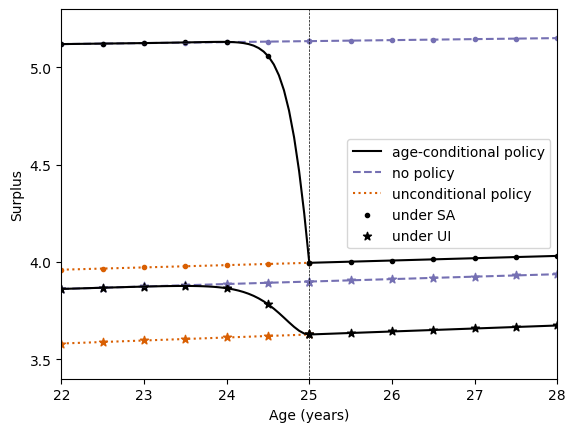

()

In [2]:
V = find_Surplus(france)
plot_surplus(V, france, xlim=(22,28), markevery=6, ylim=(3.4,5.3) ,ytic=3.5:0.5:5, loc=5)
_tosave ? savefig(joinpath(dir_graph,"surplus_$suff.png")) : ()

Plot the job-finding rates.

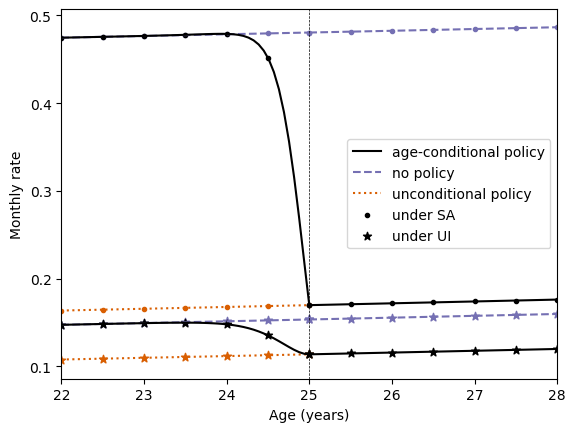

()

In [3]:
plot_JFR(V, france, xlim=(22,28), markevery=6, ytic=0.1:0.1:0.5, loc=5)
_tosave ? savefig(joinpath(dir_graph,"jfr_$suff.png")) : ()

Plot the distribution of nonemployed workers.

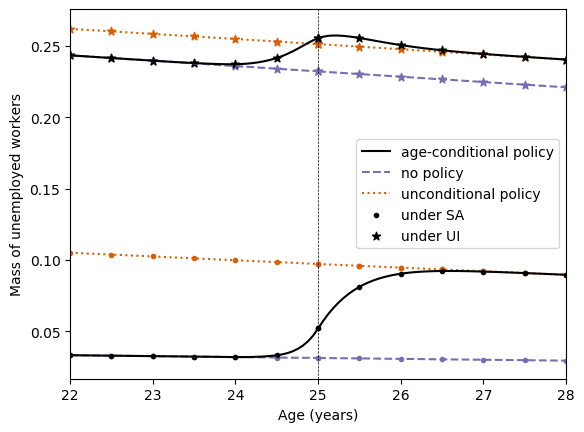

()

In [4]:
unemp = find_Unemp(V, france)
plot_unemp(unemp, france, xlim=(22,28), markevery=6, loc=5)
_tosave ? savefig(joinpath(dir_graph,"unemp_$suff.png")) : ()

Plot the dynamics of employment.

The graphical LATE is -0.08492224564630546
The rough RDD estimate LATE is -0.061879540274052514


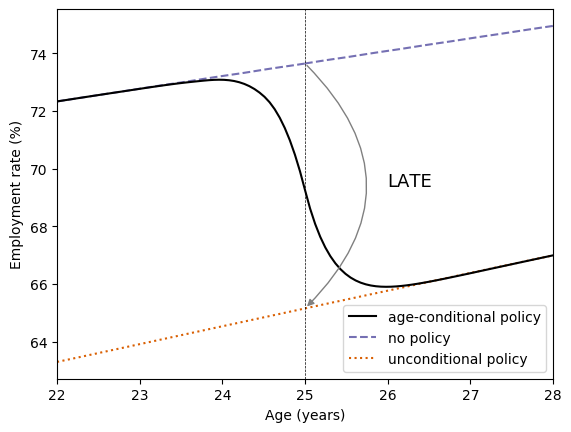

In [5]:
plot_emp(unemp, france, xlim=(22,28), loc=4) 

## add annotation
e0 = (1-sum(unemp.without(france.A))) * 100
e1 = (1-sum(unemp.with(france.A))) * 100
annotate("",
    xy=(25, e0), xytext=(25, e1),
    arrowprops= Dict(:arrowstyle => "<|-", :color => :grey,
        :connectionstyle => "arc3,rad=0.5"))
annotate("LATE", xy=(26, (e0+e1)/2), fontsize=13)
_tosave ? savefig(joinpath(dir_graph,"emp_$suff.png")) : ()

println("The graphical LATE is ", (1-sum(unemp.with(france.A))) - (1-sum(unemp.without(france.A))))
println("The rough RDD estimate LATE is ", (1-sum(unemp.real(france.A+6))) - (1-sum(unemp.real(france.A-6))))

Plot the fit.

We print the targeted and simulated moments:


7×2 Matrix{Float64}:
 0.721  0.720815
 0.664  0.667253
 0.656  0.660995
 0.676  0.666866
 0.678  0.673019
 0.676  0.679107
 0.682  0.685158

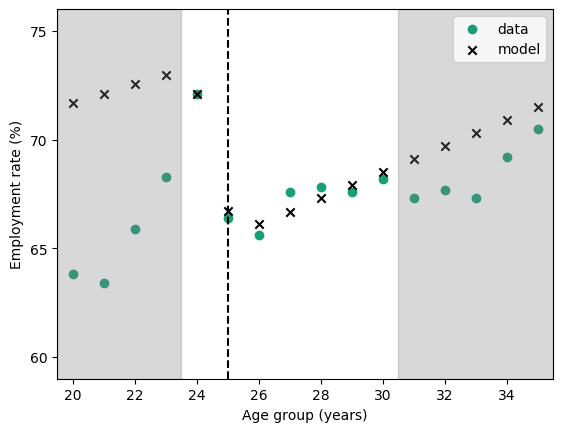

()

In [6]:
moments_model =  moments_france(unemp.real)
moments_model_all= moments_france(unemp.real, a_range=data_fra.age)
 

println("We print the targeted and simulated moments:")
display(hcat(moments_target, moments_model))


plot_fit(data_fra, moments_model_all, france,  
        xlim=(19.5,35.5), xshades=(23.5, 30.5), 
        ylim=(59,76), ytic=60:5:75)
_tosave ? savefig(joinpath(dir_graph,"fit_$suff.png")) : ()

# 2) RDD with simulated model
We generate the simulated data points. For each age $a$ (in years) between 20 and 35, we define $Y$ as the average employment rate between $a$ and $a+1$. 

In [7]:
let
age_grid = (20:35) *12
Y = [quadgk(x->1-sum(unemp.real(x)[:]) ,a,a+12, atol=1e-8)[1]/12 for a in age_grid] 

table = zeros(5)

#explaining variables
TREAT = [a>=france.A for a in age_grid]
consta = ones(size(age_grid))
age1 = collect(age_grid)
age2 = age1 .^2
age3 = age1 .^3
age1_spl = (age1 .- france.A) .* TREAT 
age2_spl = (age1 .- france.A).^2 .* TREAT 

# linear
X = hcat(TREAT, consta, age1)
beta = inv(X' * X) * (X' * Y)
table[1] = beta[1]

# quadratic
X = hcat(TREAT, consta, age1, age2)
beta = inv(X' * X) * (X' * Y)
table[2] = beta[1]

# cubic
X = hcat(TREAT, consta, age1, age2, age3)
beta = inv(X' * X) * (X' * Y)
table[3] = beta[1]

# linear spline, with different age window
X = hcat(TREAT, consta, age1, age1_spl)
beta = inv(X' * X) * (X' * Y)
table[4] = beta[1]
  
# quadratic spline
X = hcat(TREAT, consta, age1, age2, age1_spl, age2_spl)
beta = inv(X' * X) * (X' * Y)
table[5] = beta[1] 


## RDD estimates from the data on the left
display(hcat([0.027,0.067,-0.065,-0.049,-0.067] ,table))
end

5×2 Matrix{Float64}:
  0.027  -0.077684
  0.067  -0.0676624
 -0.065  -0.067849
 -0.049  -0.0687714
 -0.067  -0.0524841

Robustness for different $q_A$ in Appendix.

In [8]:
mytab = let
    par = [0.01 0.025 0.05 0.075 0.1; 0.22849509692057998 0.3117478108428948 0.2607359798656053 0.23967448574973638 0.4071137102919489; 0.04073389331497086 0.10482000306832813 0.20474363913214377 0.3029013451226111 0.4427410794792553; -3.712082211914822e-5 -4.8412393275282786e-5 -6.099046958730697e-5 -7.60204363645744e-5 -9.685986337504315e-5]
    ncol = size(par)[1]
    out = vcat(par, zeros(7,5)) 
    DataFrame(out, :auto)
end


## for each alternative set of parameters
@time for i in 1:ncol(mytab)
    newC = update_Country1(α=mytab[2,i], m=mytab[3,i], q0=mytab[1,i], qa=mytab[4,i]) 
    mytab[5,i] = newC.λ
    newV = find_Surplus(newC)
    newunemp = find_Unemp(newV, newC) 
    
    #Employment rates
    mytab[6:8,i] = [quadgk(x->1-sum(newunemp.real(x)[:]) ,a, a+12, atol=1e-8)[1]/12 for a in (24:26)*12]

    ## Estimates
    age_grid = (20:35)*12
    Y = [quadgk(x->1-sum(newunemp.real(x)[:]) ,a,a+12, atol=1e-8)[1]/12 for a in age_grid] 
    TREAT = [a>=newC.A for a in age_grid]
    consta = ones(size(age_grid))
    age1 = collect(age_grid)
    age1_spl = (age1 .- newC.A) .* TREAT 
    X = hcat(TREAT, consta, age1, age1_spl)
    beta = inv(X' * X) * (X' * Y)
    mytab[9,i] = -0.049 
    mytab[10,i] = beta[1]
    
    ## LATE
    emp_after = 1-sum(newunemp.with(newC.A)[:])
    emp_before = 1-sum(newunemp.without(newC.A)[:])
    mytab[11,i] = emp_after-emp_before   
end
mytab

  0.580414 seconds (632.78 k allocations: 40.295 MiB, 2.80% gc time, 96.96% compilation time)


Row,x1,x2,x3,x4,x5
,Float64,Float64,Float64,Float64,Float64
1,0.01,0.025,0.05,0.075,0.1
2,0.228495,0.311748,0.260736,0.239674,0.407114
3,0.0407339,0.10482,0.204744,0.302901,0.442741
4,-3.71208e-5,-4.84124e-5,-6.09905e-5,-7.60204e-5,-9.68599e-5
5,0.0369089,0.0428786,0.0546188,0.0688908,0.0860489
6,0.707994,0.714972,0.719807,0.721003,0.714665
7,0.682921,0.677804,0.670324,0.666529,0.66729
8,0.667561,0.662322,0.660281,0.661348,0.664798
9,-0.049,-0.049,-0.049,-0.049,-0.049


Robustness for different $\xi$ in Appendix.

In [9]:
mytab = let
    par = [0.0 0.25 0.5 0.75 1.0; 0.23934241405757434 0.2821534976596658 0.31618156437721234 0.33691609577306375 0.3602653271142106; 0.2299570521500436 0.27818244149516286 0.29151429088961134 0.38448245638360956 0.3810033261602324; 0.056983800301068 0.06732680444966312 0.06956356120250261 0.09094442237528229 0.08951757491483667; -6.455667869386995e-5 -8.148878990117824e-5 -9.246745113898855e-5 -0.0001170258767406586 -0.00012405218047344347]
    ncol = size(par)[1]
    out = vcat(par, zeros(7,5)) 
    DataFrame(out, :auto)
end


## for each alternative set of parameters
@time for i in 1:ncol(mytab)
    newC = update_Country1(α=mytab[2,i], m=mytab[3,i], q0=mytab[4,i], qa=mytab[5,i], ξ=mytab[1,i]) 
    mytab[6,i] = newC.λ
    newV = find_Surplus(newC)
    newunemp = find_Unemp(newV, newC) 
    
    #Employment rates
    mytab[7:9,i] = [quadgk(x->1-sum(newunemp.real(x)[:]),a, a+12, atol=1e-8)[1]/12 for a in (24:26)*12]

    ## Estimates
    age_grid = (20:35)*12
    Y = [quadgk(x->1-sum(newunemp.real(x)[:]) ,a,a+12, atol=1e-8)[1]/12 for a in age_grid] 
    TREAT = [a>=newC.A for a in age_grid]
    consta = ones(size(age_grid))
    age1 = collect(age_grid)
    age1_spl = (age1 .- newC.A) .* TREAT 
    X = hcat(TREAT, consta, age1, age1_spl)
    beta = inv(X' * X) * (X' * Y)
    mytab[10,i] = -0.049 
    mytab[11,i] = beta[1]
    
    ## LATE
    emp_after = 1-sum(newunemp.with(newC.A)[:])
    emp_before = 1-sum(newunemp.without(newC.A)[:])
    mytab[12,i] = emp_after-emp_before   
end
mytab

  0.602961 seconds (681.30 k allocations: 43.273 MiB, 3.37% gc time, 97.88% compilation time)


Row,x1,x2,x3,x4,x5
,Float64,Float64,Float64,Float64,Float64
1,0.0,0.25,0.5,0.75,1.0
2,0.239342,0.282153,0.316182,0.336916,0.360265
3,0.229957,0.278182,0.291514,0.384482,0.381003
4,0.0569838,0.0673268,0.0695636,0.0909444,0.0895176
5,-6.45567e-5,-8.14888e-5,-9.24675e-5,-0.000117026,-0.000124052
6,0.058336,0.0642201,0.0655542,0.0794775,0.0784798
7,0.720996,0.720054,0.71974,0.719758,0.719634
8,0.66873,0.669792,0.671525,0.670264,0.67188
9,0.66018,0.659993,0.659238,0.65973,0.658913


# 3) Discussion
The role of $m$ and $q$

In [10]:
## function to evaluate bias for given parameters
function whatbias(; m=france.m, q0=france.q0, qa=france.qa, Aret=france.Aret, ξ=france.ξ)
    age_grid = (20:35)*12
    newC = update_Country1(α=france.α, m=m, q0=q0, qa=qa, Aret=Aret, ξ=ξ)
    newV =  find_Surplus(newC)
    newunemp = find_Unemp(newV, newC) 

    ## RDD estimate 
    Y = [quadgk(x->1-sum(newunemp.real(x)[:]) ,a,a+12)[1]/12 for a in age_grid] 
    TREAT = [a>=france.A for a in age_grid]
    consta = ones(size(age_grid))
    age1 = collect(age_grid)
    age1_spl = (age1 .- france.A) .* TREAT 
    X = hcat(TREAT, consta, age1, age1_spl )
    beta = inv(X' * X) * (X' * Y)
    RDDestimate = beta[1]

    ## LATE
    emp_after = 1-sum(newunemp.with(newC.A)[:])
    emp_before = 1-sum(newunemp.without(newC.A)[:])
    LATE = emp_after-emp_before
    return (RDDestimate, LATE)
end

whatbias (generic function with 1 method)

In [11]:
## get datapoints for the 3D graph
Ndata = 400 #400
logscale = 2
data3D = zeros(Ndata^2,5)
i0 = 0
selecX = []
selecY = []
mdec_vec = vcat(range(-1,stop=0,length=Integer(Ndata/2)),range(0.001,stop=1,length=Integer(Ndata/2)))
qdec_vec = vcat(range(-1,stop=0,length=Integer(Ndata/2)),range(0.001,stop=1,length=Integer(Ndata/2)))
i=0
@time for mdec in mdec_vec, qdec in qdec_vec
    i +=1
    newm = france.m*logscale^mdec
    newq0 = france.q0*logscale^qdec
    (RDDestimate, LATE) = whatbias(m=newm, q0=newq0)

    data3D[i,:] = [mdec, qdec, -RDDestimate, -LATE , RDDestimate-LATE] 
  #=  if (mdec == 0) & (newq0 <= france.q0 )
        push!(selecY, i)
    end
    if (qdec == 0) & (newm >= france.m )
        push!(selecX, i)
end=#
    if (mdec == 0) & (qdec == 0)
        i0 = i
    end
end

311.474614 seconds (3.18 G allocations: 209.997 GiB, 12.69% gc time, 0.17% compilation time)


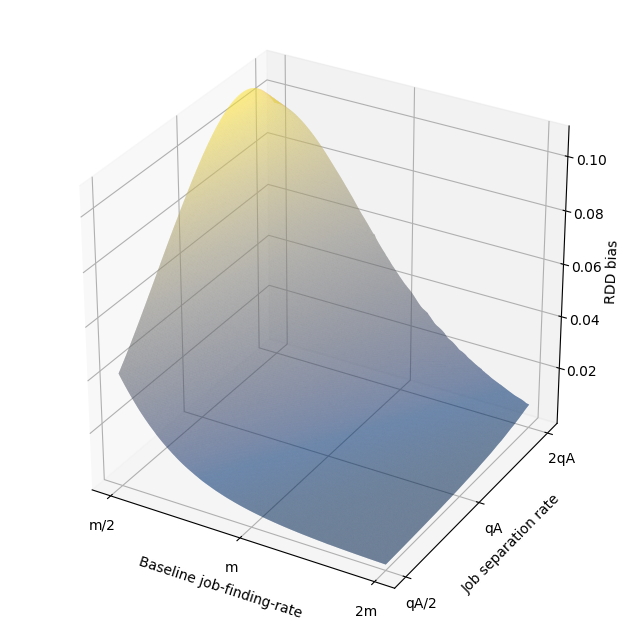

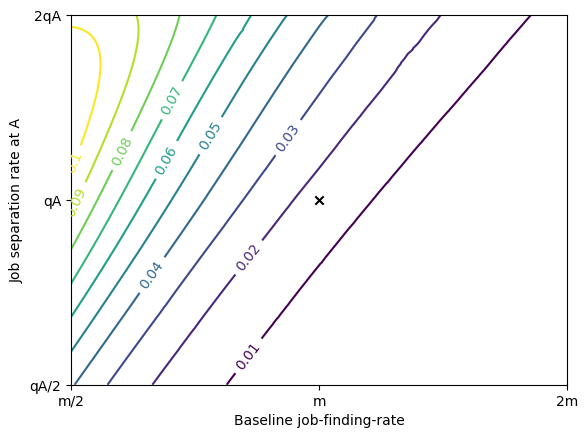

()

In [12]:
### RDD Bias
mycol = 5
figure(figsize=(8,8))
surf(data3D[:,1],data3D[:,2],data3D[:,mycol], cmap = :cividis, alpha=0.75)
#plot3D(data3D[selecX,1], data3D[selecX,2], data3D[selecX,mycol] , linestyle=:dotted, color=:black, alpha=1.)
#plot3D(data3D[selecY,1], data3D[selecY,2], data3D[selecY,mycol] , linestyle=:dotted, color=:black)
#scatter3D(data3D[i0,1],data3D[i0,2],data3D[i0,mycol], s=200, color=:black, marker="x")
xlabel("Baseline job-finding-rate")
ylabel("Job separation rate")
zlabel("RDD bias")
#zlim([0,0.012])
xticks([-1,0,1], ["m/$logscale","m","$(logscale)m"])
yticks([-1,0,1], ["qA/$logscale","qA","$(logscale)qA"])
#println("The cross is at Z= ", data3D[i0,5])
_tosave ? savefig(joinpath(dir_graph,"RDD3D_$suff.png")) : ()

figure()
CS = contour(mdec_vec,qdec_vec,reshape(data3D[:,mycol],Ndata,Ndata),
                 levels=0.01:0.01:0.1)
              #  levels=vcat(0.005, 0.01, 0.02, 0.04:0.04:0.28))
clabel(CS, inline=1, fontsize=10, fmt="%0.3g")
scatter(0,0, color=:black, marker="x")
xlabel("Baseline job-finding-rate")
ylabel("Job separation rate at A")
xticks([-1,0,1], ["m/$logscale","m","$(logscale)m"])
yticks([-1,0,1], ["qA/$logscale","qA","$(logscale)qA"])
_tosave ? savefig(joinpath(dir_graph,"RDD_$suff.png")) : ()

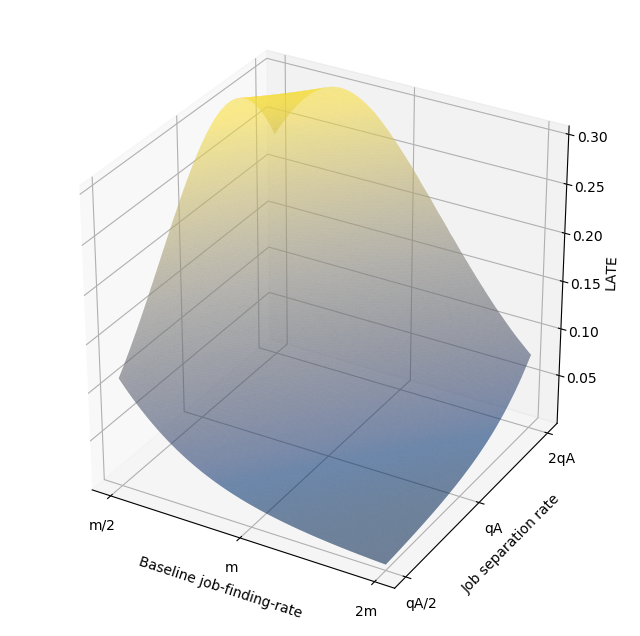

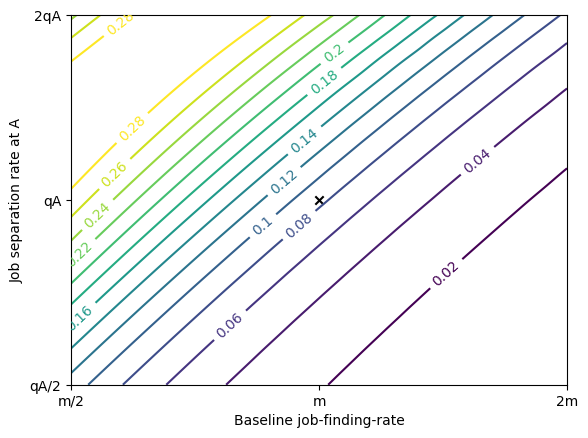

()

In [13]:
### LATE
mycol = 4
figure(figsize=(8,8))
surf(data3D[:,1],data3D[:,2],data3D[:,mycol], cmap = :cividis, alpha=0.75)
#plot3D(data3D[selecX,1], data3D[selecX,2], data3D[selecX,mycol] , linestyle=:dotted, color=:black, alpha=1.)
#plot3D(data3D[selecY,1], data3D[selecY,2], data3D[selecY,mycol] , linestyle=:dotted, color=:black)
#scatter3D(data3D[i0,1],data3D[i0,2],data3D[i0,mycol], s=200, color=:black, marker="x")
xlabel("Baseline job-finding-rate")
ylabel("Job separation rate")
zlabel("LATE ")
#zlim([0,0.012])
xticks([-1,0,1], ["m/$logscale","m","$(logscale)m"])
yticks([-1,0,1], ["qA/$logscale","qA","$(logscale)qA"])
#println("The cross is at Z= ", data3D[i0,5])
_tosave ? savefig(joinpath(dir_graph,"LATE3D_$suff.png")) : ()

figure()
CS = contour(mdec_vec,qdec_vec,reshape(data3D[:,mycol],Ndata,Ndata),
                levels=0.02:0.02:0.28)
                #levels=vcat(0.01, 0.02, 0.04, 0.06, 0.08, 0.12:0.06:0.3))
clabel(CS, inline=1, fontsize=10, fmt="%0.3g")
scatter(0,0, color=:black, marker="x")
xlabel("Baseline job-finding-rate")
ylabel("Job separation rate at A")
xticks([-1,0,1], ["m/$logscale","m","$(logscale)m"])
yticks([-1,0,1], ["qA/$logscale","qA","$(logscale)qA"])
_tosave ? savefig(joinpath(dir_graph,"LATE_$suff.png")) : ()

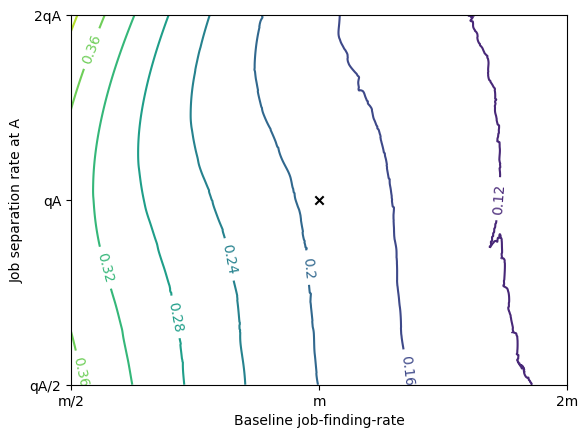

()

In [14]:
### RDD Bias in share
figure()
CS = contour(mdec_vec,qdec_vec,reshape(data3D[:,5] ./ data3D[:,4],Ndata,Ndata))
             #   levels=vcat(0.005, 0.01, 0.02, 0.04:0.04:0.28))
clabel(CS, inline=1, fontsize=10, fmt="%0.3g")
scatter(0,0, color=:black, marker="x")
xlabel("Baseline job-finding-rate")
ylabel("Job separation rate at A")
xticks([-1,0,1], ["m/$logscale","m","$(logscale)m"])
yticks([-1,0,1], ["qA/$logscale","qA","$(logscale)qA"])
_tosave ? savefig(joinpath(dir_graph,"RDDshare_$suff.png")) : ()

In [15]:
## table of bias
makerow(text, RDD, LATE) = [text round(RDD,digits=3) round(LATE,digits=3) round((RDD-LATE)/(abs(LATE))*100,digits=1)]
function makerow(text::String, wb)
    (RDD, LATE) = wb
    println("The estimate and LATE $text are $RDD and $LATE")
    return makerow(text, RDD, LATE) 
end

mytab = DataFrame(makerow("in the calibrated model", whatbias()), :auto)
#push!(mytab, makerow("m / 2", whatbias(m=france.m/2)))
push!(mytab, makerow("without trend", whatbias(qa=0.)))
push!(mytab, makerow("without horizon", whatbias(Aret=1000. *12)))

for aa in [45, 40]
    push!(mytab, makerow("with horizon at $aa", whatbias(Aret=aa *12.)))
end

The estimate and LATE in the calibrated model are -0.06877142624219346 and -0.08492224564630546
The estimate and LATE without trend are -0.06950787487845389 and -0.08453853568703695
The estimate and LATE without horizon are -0.06877142919445589 and -0.08492225733625225
The estimate and LATE with horizon at 45 are -0.06877142670684577 and -0.08492224981037688
The estimate and LATE with horizon at 40 are -0.06877212742210759 and -0.08492224885714772


In [16]:
## bias with uncertainty
for xi in 0.25:0.25:1
    push!(mytab, makerow("with uncertainty $xi", whatbias(ξ=xi)))
end

The estimate and LATE with uncertainty 0.25 are -0.07052133825963836 and -0.08492224564630546
The estimate and LATE with uncertainty 0.5 are -0.07205690706614121 and -0.08492224564630546
The estimate and LATE with uncertainty 0.75 are -0.07340798688304062 and -0.08492224564630546
The estimate and LATE with uncertainty 1.0 are -0.07455947083121828 and -0.08492224564630546


In [17]:
## bias if we use job-finding rates
function average_JFR(a::Float64, uvec, Svec, C::Country1A)
    num = uvec[1] * JFR(Svec[1], C) + uvec[2] * JFR(Svec[2], C) 
    den = sum(uvec)
    return num/den
end

function whatbias_JFR(;m=france.m, q0=france.q0, qa=france.qa, Aret=france.Aret, ξ=france.ξ)
    age_grid = (20:35)*12
    newC = update_Country1(α=france.α, m=m, q0=q0, qa=qa, Aret=Aret, ξ=ξ)
    newV =  find_Surplus(newC)
    newunemp = find_Unemp(newV, newC) 

    ## RDD estimate 
    auxfun = a -> a>france.A ? average_JFR(a, newunemp.real(a), newV.Σ(a), newC) : average_JFR(a, newunemp.real(a), newV.S(a), newC) 
    #Y = [auxfun(a) for a in 12. * age_grid]
    Y = [quadgk(auxfun,a,a+12)[1]/12 for a in age_grid]
    TREAT = [a>=france.A for a in age_grid]
    consta = ones(size(age_grid))
    age1 = collect(age_grid)
    age1_spl = (age1 .- france.A) .* TREAT 
    X = hcat(TREAT, consta, age1, age1_spl )
    beta = inv(X' * X) * (X' * Y)
    RDDestimate = beta[1]

    ## LATE
    emp_after = average_JFR(newC.A, newunemp.with(newC.A), newV.Σ(newC.A), newC)
    emp_before = average_JFR(newC.A, newunemp.without(newC.A), newV.Ψ(newC.A), newC)
    LATE = emp_after-emp_before
    return (RDDestimate, LATE)
end

#JFR_without = average_JFR(france.A, unemp.without(france.A), V.Ψ(france.A), france)
#JFR_with = average_JFR(france.A, unemp.with(france.A), V.Σ(france.A), france)
#println("Back-of-the-envelope LATE on employment ", JFR_with/(JFR_with+france.q0) - JFR_without/(JFR_without+france.q0) )
JFR_after = average_JFR(france.A, unemp.real(france.A), V.Σ(france.A), france)


boteRDD(RDD_JFR ,LATE_JFR) = JFR_after/(JFR_after+france.q0) - (JFR_after-RDD_JFR)/(JFR_after-RDD_JFR+france.q0) 
function makerow_JFR(text, wb)
    println("$text")
    (RDD ,LATE) = whatbias()
    (RDD_JFR ,LATE_JFR) = wb
    println("When considering the average JFR, the RDD estimate and LATE are $RDD_JFR and $LATE_JFR")
    bote = boteRDD(RDD_JFR ,LATE_JFR)
    println("Back-of-the-envelope calculation give and RDD on employment at $bote")
    # push!(mytab, )
    println("If the RDD was right, we would obtain ", JFR_after/(JFR_after+france.q0) - (JFR_after-LATE_JFR)/(JFR_after-LATE_JFR+france.q0) )
    return makerow(text, bote, LATE) 
end

## with JFR and uncertainty
for xi in 0:0.25:1
    push!(mytab, makerow_JFR("--JFR and uncertainty at xi=$xi--", whatbias_JFR(ξ=xi)));
end

mytab

--JFR and uncertainty at xi=0.0--
When considering the average JFR, the RDD estimate and LATE are -0.04412116254282594 and -0.06310994262453981
Back-of-the-envelope calculation give and RDD on employment at -0.06688699491349037
If the RDD was right, we would obtain -0.08853406464521041
--JFR and uncertainty at xi=0.25--
When considering the average JFR, the RDD estimate and LATE are -0.049557038212427074 and -0.06310994262453981
Back-of-the-envelope calculation give and RDD on employment at -0.07343247939601927
If the RDD was right, we would obtain -0.08853406464521041
--JFR and uncertainty at xi=0.5--
When considering the average JFR, the RDD estimate and LATE are -0.05475766255355197 and -0.06310994262453981
Back-of-the-envelope calculation give and RDD on employment at -0.07942404218219046
If the RDD was right, we would obtain -0.08853406464521041
--JFR and uncertainty at xi=0.75--
When considering the average JFR, the RDD estimate and LATE are -0.05975149334234686 and -0.0631099426

Row,x1,x2,x3,x4
,Any,Any,Any,Any
1,in the calibrated model,-0.069,-0.085,19.0
2,without trend,-0.07,-0.085,17.8
3,without horizon,-0.069,-0.085,19.0
4,with horizon at 45,-0.069,-0.085,19.0
5,with horizon at 40,-0.069,-0.085,19.0
6,with uncertainty 0.25,-0.071,-0.085,17.0
7,with uncertainty 0.5,-0.072,-0.085,15.1
8,with uncertainty 0.75,-0.073,-0.085,13.6
9,with uncertainty 1.0,-0.075,-0.085,12.2
